'padchest_pneumonia_normal_en.csv' was provided by Wafa and conteins reports translated by Google Translator as well as ChatGPT. 

### Libraries importing

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import defaultdict
from collections import Counter

from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

import shap

In [2]:
pd.options.mode.chained_assignment = None

### Dataset importing

In [3]:
df = pd.read_csv('padchest_pneumonia_normal_en.csv')
df.head()

,ImageID,StudyDate_DICOM,StudyID,PatientID,PatientBirth,PatientSex_DICOM,ViewPosition_DICOM,ReportID,Pediatric,Report,MethodLabel,Labels,Localizations,LabelsLocalizationsBySentence,PatientAge,Report_en_ChatGPT,Report_en_GoogleTr
0,20536686640136348236148679891455886468_k6ga29.png,20140915,20536686640136348236148679891455886468,839860488694292331637988235681460987,1930.0,F,POSTEROANTERIOR,4765777,NO,sin hallazg patolog edad pacient,Physician,normal,[],"[['normal'], ['normal']]",84.0,There are no pathological findings in the pati...,no finding pathology patient age
1,238285621348398466668514178112618553012_a7k6dv...,20171024,238285621348398466668514178112618553012,76478060312810134599679306720116852498,1987.0,F,POSTEROANTERIOR,5498692,NO,sin alter radiolog significacion,Physician,normal,[],"[['normal'], ['normal']]",30.0,"Translation: ""Without any other significant ra...",without alter radiolog significance
2,152191969602076825998375638267191596461_ck9qkz...,20150508,152191969602076825998375638267191596461,211676018114322936525876155155978326212,1958.0,F,POSTEROANTERIOR,4913344,NO,sin hallazg radiolog signific,Physician,normal,[],[['normal']],57.0,"Translation: ""no significant radiological find...",no significant radiological finding
3,84289138814897824414670894017743137660_xjsw7k.png,20140414,84289138814897824414670894017743137660,132905598244344199302356904572008903408,1997.0,F,POSTEROANTERIOR,4674875,PED,normal,Physician,normal,[],"[['normal'], ['normal']]",17.0,"""Normal""",normal
4,243837679625088918208093479515843617254_zotvy7...,20160210,243837679625088918208093479515843617254,122113458248232192114674752959967366181,1976.0,F,LATERAL,5084816,NO,siluet cardiomediastin dentr normal parenqu...,Physician,normal,"['loc cardiac', 'loc costophrenic angle']","[['normal'], ['normal'], ['normal', 'loc cardi...",40.0,"Text: ""Normal silhouette in cardiomediatinum a...",Siluet cardiomediastin within normal lung pare...


### Data types verification

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7975 entries, 0 to 7974
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ImageID                        7975 non-null   object 
 1   StudyDate_DICOM                7975 non-null   int64  
 2   StudyID                        7975 non-null   object 
 3   PatientID                      7975 non-null   object 
 4   PatientBirth                   7975 non-null   float64
 5   PatientSex_DICOM               7975 non-null   object 
 6   ViewPosition_DICOM             7975 non-null   object 
 7   ReportID                       7975 non-null   int64  
 8   Pediatric                      7975 non-null   object 
 9   Report                         7972 non-null   object 
 10  MethodLabel                    7975 non-null   object 
 11  Labels                         7975 non-null   object 
 12  Localizations                  7975 non-null   o

### Missing values and duplicates check

In [5]:
df.isna().sum().any()

True

In [6]:
missing_values = df.isna().sum()
missing_values = missing_values[missing_values > 0]
missing_values

Report                3
Report_en_GoogleTr    3
dtype: int64

In [7]:
df[df['Report'].isna()]

,ImageID,StudyDate_DICOM,StudyID,PatientID,PatientBirth,PatientSex_DICOM,ViewPosition_DICOM,ReportID,Pediatric,Report,MethodLabel,Labels,Localizations,LabelsLocalizationsBySentence,PatientAge,Report_en_ChatGPT,Report_en_GoogleTr
801,130089266019031321486757938202118853737_0wylau...,20140729,130089266019031321486757938202118853737,330043840283697623087388082822833276119,1945.0,M,POSTEROANTERIOR,4740545,NO,NaN,Physician,normal,[],"[['normal'], ['exclude'], ['exclude'], ['exclu...",69.0,"Sorry, but I need more context or specific tex...",NaN
2206,270874360595877956815863527868805394662_cqysk4...,20140812,270874360595877956815863527868805394662,248163031148542822922794092367428665674,1960.0,M,LATERAL,4737923,NO,NaN,Physician,normal,[],"[['normal'], ['exclude'], ['exclude'], ['exclu...",54.0,"Sorry, but I need more context or specific tex...",NaN
2207,270874360595877956815863527868805394662_cqysk2...,20140812,270874360595877956815863527868805394662,248163031148542822922794092367428665674,1960.0,M,POSTEROANTERIOR,4737923,NO,NaN,Physician,normal,[],"[['normal'], ['exclude'], ['exclude'], ['exclu...",54.0,"Sorry, but I need more context or specific tex...",NaN


We have three recordings with NaN in Report, and the belong to Labels = normal. Since the amount of NaN-values is small, we can drop these three recordings.

In [8]:
df = df.dropna()
df.shape

(7972, 17)

In [9]:
df.duplicated().any()

False

### Pneumonia/normal classes exploration

In [10]:
df[df['Labels']=='pneumonia'].shape

(523, 17)

In [11]:
df[df['Labels']=='normal'].shape

(7449, 17)

Text(0.5, 1.0, 'Labels distribution')

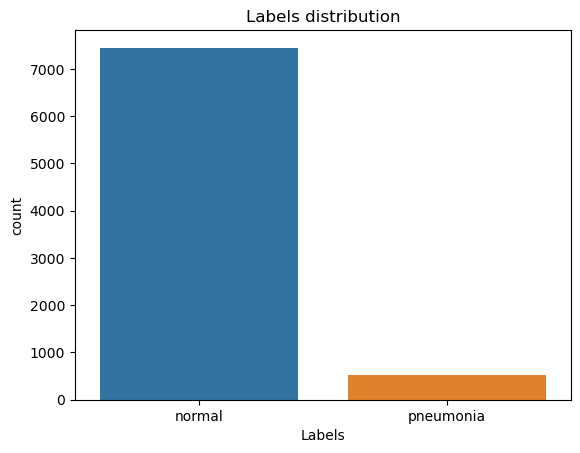

In [12]:
sns.countplot(x=df['Labels'])
plt.title('Labels distribution')

There are 523 of 'pneumonia' and 7451 'normal' recordings in the dataset. This is our class imbalance.

### Text cleaning

#### Reports translated by ChatGPT were selected for further work.

In [13]:
# normilize

df['Report_en_ChatGPT'] = df['Report_en_ChatGPT'].str.lower()
df.head(3)

,ImageID,StudyDate_DICOM,StudyID,PatientID,PatientBirth,PatientSex_DICOM,ViewPosition_DICOM,ReportID,Pediatric,Report,MethodLabel,Labels,Localizations,LabelsLocalizationsBySentence,PatientAge,Report_en_ChatGPT,Report_en_GoogleTr
0,20536686640136348236148679891455886468_k6ga29.png,20140915,20536686640136348236148679891455886468,839860488694292331637988235681460987,1930.0,F,POSTEROANTERIOR,4765777,NO,sin hallazg patolog edad pacient,Physician,normal,[],"[['normal'], ['normal']]",84.0,there are no pathological findings in the pati...,no finding pathology patient age
1,238285621348398466668514178112618553012_a7k6dv...,20171024,238285621348398466668514178112618553012,76478060312810134599679306720116852498,1987.0,F,POSTEROANTERIOR,5498692,NO,sin alter radiolog significacion,Physician,normal,[],"[['normal'], ['normal']]",30.0,"translation: ""without any other significant ra...",without alter radiolog significance
2,152191969602076825998375638267191596461_ck9qkz...,20150508,152191969602076825998375638267191596461,211676018114322936525876155155978326212,1958.0,F,POSTEROANTERIOR,4913344,NO,sin hallazg radiolog signific,Physician,normal,[],[['normal']],57.0,"translation: ""no significant radiological find...",no significant radiological finding


In [14]:
# this function was originally developed by Wafa

# remove extra symbols and comments from ChatGPT

def pre_process(text):
    sentences = re.findall(r'"(.*?)"', text)
    if len(sentences)==0:
        return(text)
    elif len(sentences) >= 2:
        second_sentence = sentences[1]
        return(second_sentence)
    else:
        return(sentences[0])

In [15]:
df['Report_en_ChatGPT'] = df['Report_en_ChatGPT'].apply(lambda x : pre_process(x))
df.head(3)

,ImageID,StudyDate_DICOM,StudyID,PatientID,PatientBirth,PatientSex_DICOM,ViewPosition_DICOM,ReportID,Pediatric,Report,MethodLabel,Labels,Localizations,LabelsLocalizationsBySentence,PatientAge,Report_en_ChatGPT,Report_en_GoogleTr
0,20536686640136348236148679891455886468_k6ga29.png,20140915,20536686640136348236148679891455886468,839860488694292331637988235681460987,1930.0,F,POSTEROANTERIOR,4765777,NO,sin hallazg patolog edad pacient,Physician,normal,[],"[['normal'], ['normal']]",84.0,there are no pathological findings in the pati...,no finding pathology patient age
1,238285621348398466668514178112618553012_a7k6dv...,20171024,238285621348398466668514178112618553012,76478060312810134599679306720116852498,1987.0,F,POSTEROANTERIOR,5498692,NO,sin alter radiolog significacion,Physician,normal,[],"[['normal'], ['normal']]",30.0,without any other significant radiological mea...,without alter radiolog significance
2,152191969602076825998375638267191596461_ck9qkz...,20150508,152191969602076825998375638267191596461,211676018114322936525876155155978326212,1958.0,F,POSTEROANTERIOR,4913344,NO,sin hallazg radiolog signific,Physician,normal,[],[['normal']],57.0,no significant radiological findings,no significant radiological finding


In [16]:
# save the dataset for further manipulations

df_ini = df.copy()

In [23]:
# define a tokenizer that picks out sequences of alphanumeric characters as tokens and drops everything else

tokenizer = RegexpTokenizer(r'\w+')
df['Report_en_ChatGPT'] = df['Report_en_ChatGPT'].map(lambda x: tokenizer.tokenize(str(x)))
df.head(3)

,ImageID,StudyDate_DICOM,StudyID,PatientID,PatientBirth,PatientSex_DICOM,ViewPosition_DICOM,ReportID,Pediatric,Report,MethodLabel,Labels,Localizations,LabelsLocalizationsBySentence,PatientAge,Report_en_ChatGPT,Report_en_GoogleTr
0,20536686640136348236148679891455886468_k6ga29.png,20140915,20536686640136348236148679891455886468,839860488694292331637988235681460987,1930.0,F,POSTEROANTERIOR,4765777,NO,sin hallazg patolog edad pacient,Physician,normal,[],"[['normal'], ['normal']]",84.0,"[there, are, no, pathological, findings, in, t...",no finding pathology patient age
1,238285621348398466668514178112618553012_a7k6dv...,20171024,238285621348398466668514178112618553012,76478060312810134599679306720116852498,1987.0,F,POSTEROANTERIOR,5498692,NO,sin alter radiolog significacion,Physician,normal,[],"[['normal'], ['normal']]",30.0,"[without, any, other, significant, radiologica...",without alter radiolog significance
2,152191969602076825998375638267191596461_ck9qkz...,20150508,152191969602076825998375638267191596461,211676018114322936525876155155978326212,1958.0,F,POSTEROANTERIOR,4913344,NO,sin hallazg radiolog signific,Physician,normal,[],[['normal']],57.0,"[no, significant, radiological, findings]",no significant radiological finding


In [ ]:
# filter stopwords

nltk.download('stopwords')
stop=stopwords.words('english')
stop.remove('no')

df['Report_en_ChatGPT'] = df['Report_en_ChatGPT'].map(lambda x: [word for word in x if not word in stop])
df.head(3)

### Analyzing text statistics

In [25]:
# create the corpus

corpus=[]
corpus=[word for i in df['Report_en_ChatGPT'] for word in i]

In [26]:
corpus

['no',
 'pathological',
 'findings',
 'patient',
 'age',
 'without',
 'significant',
 'radiological',
 'meaning',
 'no',
 'significant',
 'radiological',
 'findings',
 'normal',
 'normal',
 'silhouette',
 'cardiomediatinum',
 'area',
 'no',
 'significant',
 'pathologic',
 'infiltrations',
 'lung',
 'parenchyma',
 'clear',
 'costophrenic',
 'angle',
 'normal',
 'silhouette',
 'cardiomediatinum',
 'area',
 'no',
 'significant',
 'pathologic',
 'infiltrations',
 'lung',
 'parenchyma',
 'clear',
 'costophrenic',
 'angle',
 'no',
 'relevant',
 'findings',
 'no',
 'relevant',
 'findings',
 'no',
 'significant',
 'radiological',
 'findings',
 'no',
 'relevant',
 'findings',
 'lung',
 'parenchyma',
 'normal',
 'cardiac',
 'mediastinal',
 'silhouette',
 'no',
 'appreciable',
 'alterations',
 'thoracic',
 'cavity',
 'lung',
 'parenchyma',
 'normal',
 'cardiac',
 'mediastinal',
 'silhouette',
 'no',
 'appreciable',
 'alterations',
 'thoracic',
 'cavity',
 'no',
 'relevant',
 'findings',
 'no',
 '

<AxesSubplot: >

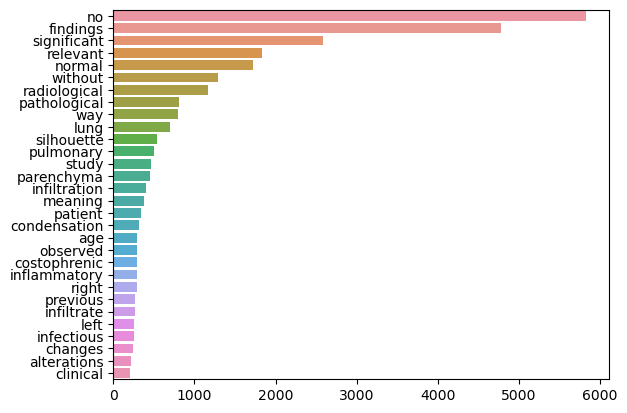

In [27]:
# count and store the occurrences of each word

counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:30]:
    x.append(word)
    y.append(count)

sns.barplot(x=y,y=x)

The most common words are 'no', 'finding' (no findings), 'significant', 'normal' that corresponds the bigger 'normal' class.

What do the words statistics look like for ‘pneumonia’ and ‘normal’ classes separately?

Text(0.5, 1.0, "'normal' class")

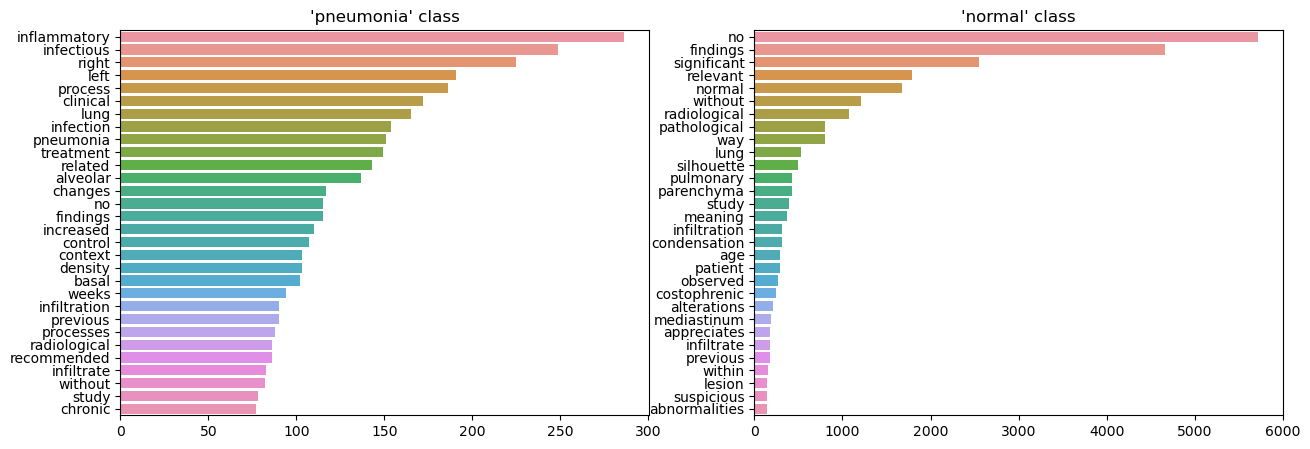

In [28]:
# do the same for the separate classes

corpus_pneumonia=[]
corpus_pneumonia=[word for i in df['Report_en_ChatGPT'][df['Labels']=='pneumonia'] for word in i]
counter_pneumonia=Counter(corpus_pneumonia)
most_pneumonia=counter_pneumonia.most_common()
x1, y1= [], []
for word,count in most_pneumonia[:30]:
    x1.append(word)
    y1.append(count)

corpus_normal=[]
corpus_normal=[word for i in df['Report_en_ChatGPT'][df['Labels']=='normal'] for word in i]
counter_normal=Counter(corpus_normal)
most_normal=counter_normal.most_common()
x2, y2= [], []
for word,count in most_normal[:30]:
    x2.append(word)
    y2.append(count)

fig, ax = plt.subplots(1, 2, figsize=(15,5))    
sns.barplot(x=y1,y=x1, ax=ax[0])
ax[0].set_title("'pneumonia' class")
sns.barplot(x=y2,y=x2, ax=ax[1])
ax[1].set_title("'normal' class")

'inflammatory', 'infectious' are the most common words for the 'pneumonia' class.

### Ngram exploration

In [29]:
# create an n-gram

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:30]

We use the untokenized dataset df_ini for creating n-grams.

<AxesSubplot: >

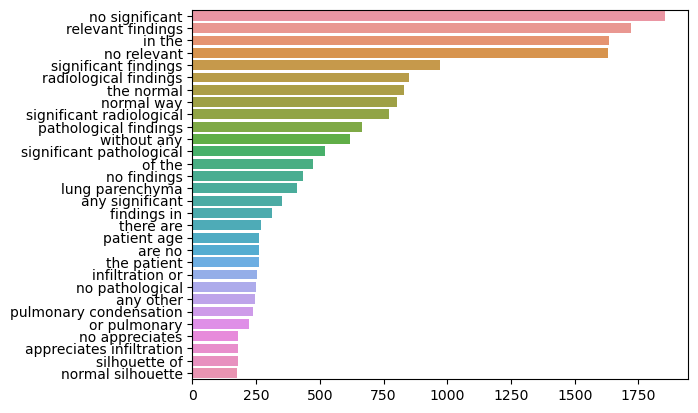

In [30]:
# plot bigram

top_n_bigrams=get_top_ngram(df_ini['Report_en_ChatGPT'],2)[:30] 
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x)

The collocations 'no significant', 'relevant findings' are used most often.

<AxesSubplot: >

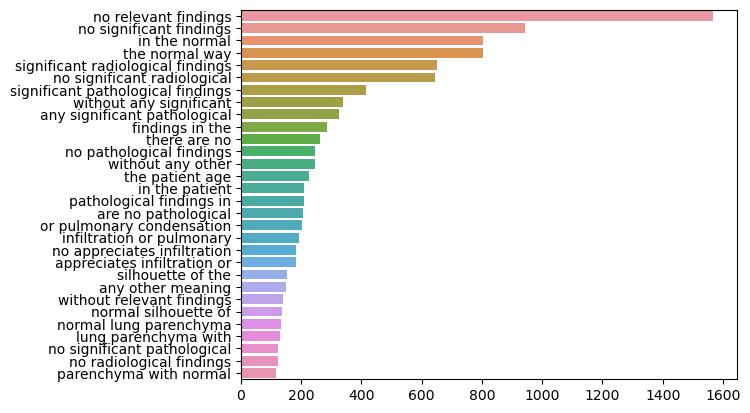

In [31]:
# plot threegram

top_n_bigrams=get_top_ngram(df_ini['Report_en_ChatGPT'],3)[:30] 
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x)

Threegram shows that the collocations 'no relevant findings', 'no significant findings' are used most often.

What do the n-grams look like for ‘pneumonia’ and ‘normal’ classes separately?

Text(0.5, 1.0, "'normal' class")

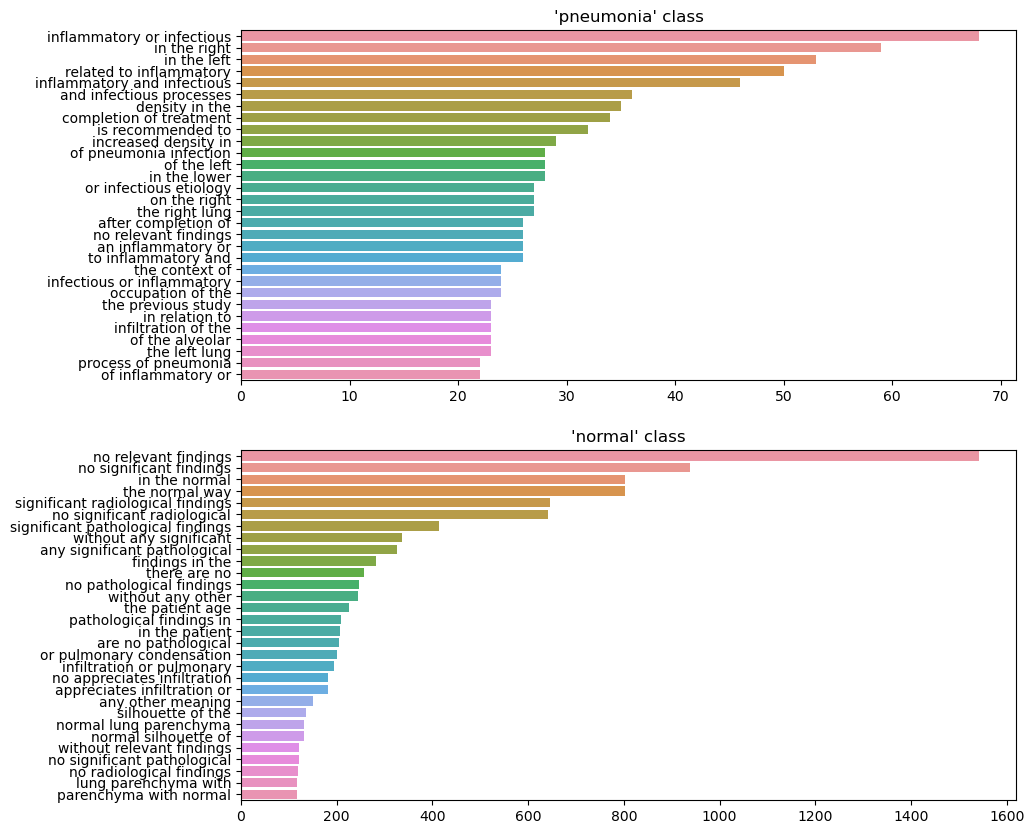

In [32]:
# threegrams

fig, ax = plt.subplots(2, 1, figsize=(10,10)) 

top_n_bigrams_pneumonia=get_top_ngram(df_ini['Report_en_ChatGPT'][df_ini['Labels']=='pneumonia'],3)[:30] 
x1,y1=map(list,zip(*top_n_bigrams_pneumonia)) 

top_n_bigrams_normal=get_top_ngram(df_ini['Report_en_ChatGPT'][df_ini['Labels']=='normal'],3)[:30] 
x2,y2=map(list,zip(*top_n_bigrams_normal))

sns.barplot(x=y1,y=x1, ax=ax[0])
ax[0].set_title("'pneumonia' class")
sns.barplot(x=y2,y=x2, ax=ax[1])
ax[1].set_title("'normal' class")

Text(0.5, 1.0, "'normal' class")

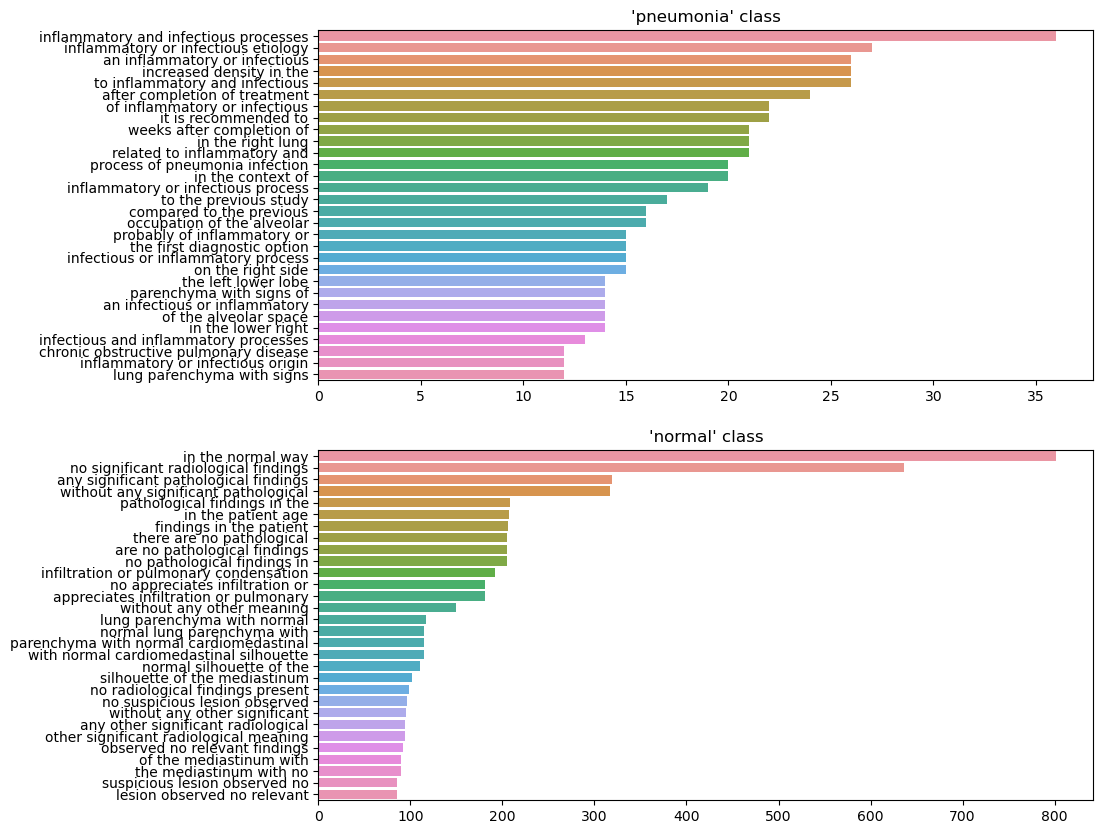

In [33]:
# fourgrams

fig, ax = plt.subplots(2, 1, figsize=(10,10)) 

top_n_bigrams_pneumonia=get_top_ngram(df_ini['Report_en_ChatGPT'][df_ini['Labels']=='pneumonia'],4)[:30] 
x1,y1=map(list,zip(*top_n_bigrams_pneumonia)) 

top_n_bigrams_normal=get_top_ngram(df_ini['Report_en_ChatGPT'][df_ini['Labels']=='normal'],4)[:30] 
x2,y2=map(list,zip(*top_n_bigrams_normal))

sns.barplot(x=y1,y=x1, ax=ax[0])
ax[0].set_title("'pneumonia' class")
sns.barplot(x=y2,y=x2, ax=ax[1])
ax[1].set_title("'normal' class")

Fourgrams show that the most common collocations are:
- 'inflammatory and infectious processes', 'inflammatory or infectious etiology' for 'pneumonia' class
- 'in the normal way', 'no significant radiological findings' for 'normal' class

### Wordcloud

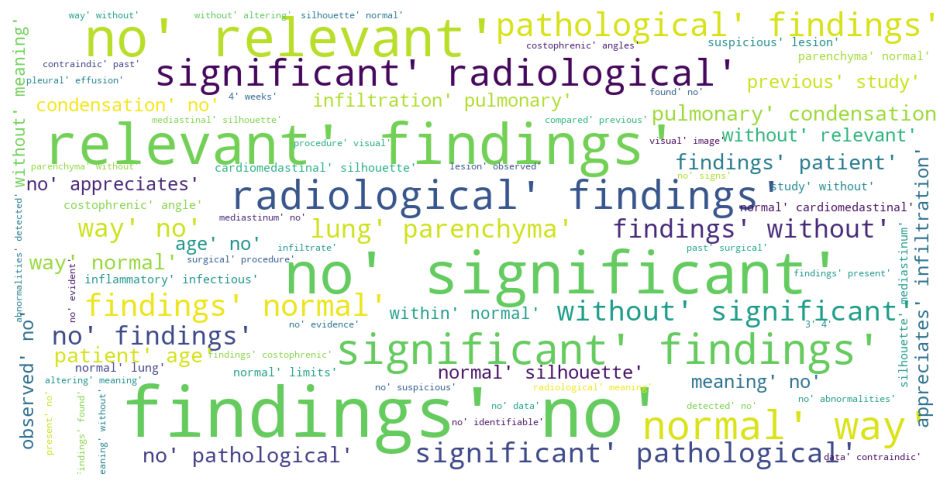

In [34]:
# create wordcloud

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stop,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

Using wordcloud, we can see what words are used the most often.

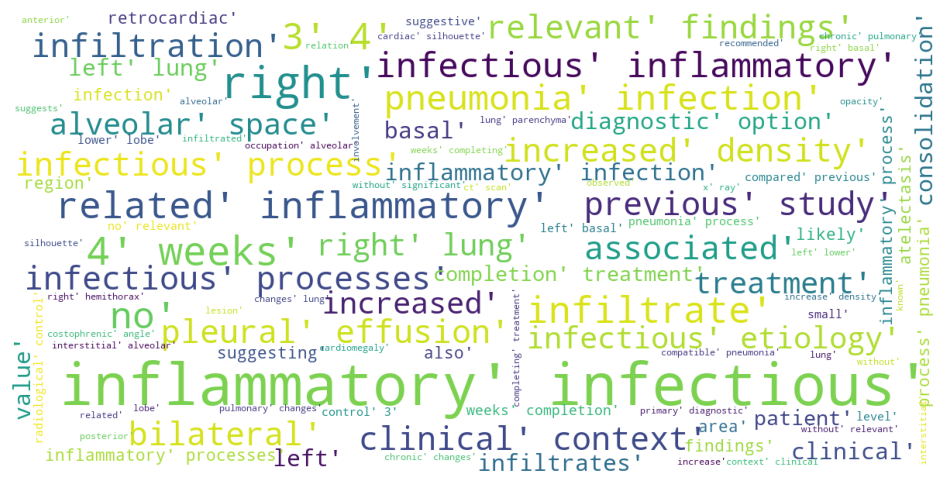

In [35]:
# for 'pneumonia' class

show_wordcloud(corpus_pneumonia)

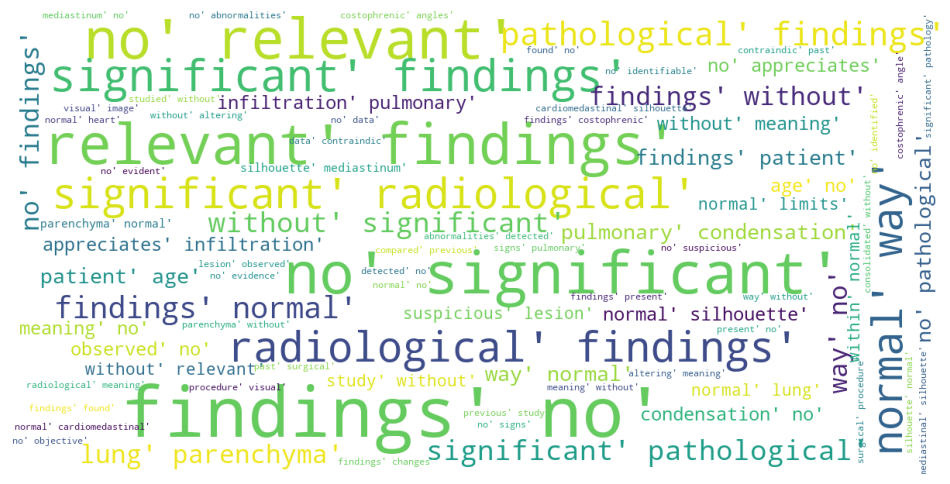

In [36]:
# for 'normal' class

show_wordcloud(corpus_normal)

### Splitting the dataset to training and validation parts, and test part

In [37]:
# work with the training-validation part

df_train_val = df_ini[:7000]
df_train_val.shape

(7000, 17)

In [38]:
# keep the test part for later

df_test = df_ini[7000:]
df_test.shape

(972, 17)

#### Checking data leakage

In [39]:
# this function checks data leakage of the dataset, and was originally developed by Saurabh Bhardwaj

def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """
 
    df1_patients_unique = df1[patient_col].nunique()
    df2_patients_unique = df2[patient_col].nunique()
    
    patients_in_both_groups = df1_patients_unique+df2_patients_unique

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(list(set(df1[patient_col].values).intersection(set(df2[patient_col].values)))) > 0 # boolean (true if there is at least 1 patient in both groups)
    
    ### END CODE HERE ###
    
    return leakage

In [40]:
# check data leakage between training-validation part and test part by PatientID

check_for_leakage(df_train_val, df_test, 'PatientID')

False

### Preparation for the modeling stage

In [42]:
# remove stop words because df_train_val was extracted from df_ini which was not cleaned from stop words 

ps = PorterStemmer()
detokenizer = TreebankWordDetokenizer()

df_train_val['Report_en_ChatGPT'] = df_train_val['Report_en_ChatGPT'].map(lambda x: tokenizer.tokenize(str(x)))
df_train_val['Report_en_ChatGPT'] = df_train_val['Report_en_ChatGPT'].map(lambda x: \
                                                                          [ps.stem(word) for word in x if not word in stop])
df_train_val['Report_en_ChatGPT'] = df_train_val['Report_en_ChatGPT'].map(lambda x: detokenizer.detokenize(x))
df_train_val['Report_en_ChatGPT']

0                            no patholog find patient age
1                          without signific radiolog mean
2                               no signific radiolog find
3                                                  normal
4       normal silhouett cardiomediatinum area no sign...
                              ...                        
6998    lev increas tram bronchial vascular base right...
6999    lev increas tram bronchial vascular base right...
7000                         no patholog find patient age
7001                             no radiolog find present
7002                                           normal way
Name: Report_en_ChatGPT, Length: 7000, dtype: object

In [43]:
corpus_model = df_train_val['Report_en_ChatGPT'].values
corpus_model

array(['no patholog find patient age', 'without signific radiolog mean',
       'no signific radiolog find', ..., 'no patholog find patient age',
       'no radiolog find present', 'normal way'], dtype=object)

In [44]:
# create the Bag of Words model

X = CountVectorizer().fit_transform(corpus_model).toarray()
y = df_train_val['Labels'].values

In [45]:
# splite the dataset into the training set and validation set

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20, random_state = 0)

### Buiding the Naive Bayes model

In [47]:
# train the Naive Bayes model on the training set

classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

In [48]:
# predict the validation set results

y_pred = classifier.predict(X_val)

result = {'y_val': y_val, 'y_pred': y_pred}
df_result = pd.DataFrame(result)
df_result

,y_val,y_pred
0,normal,normal
1,pneumonia,pneumonia
2,normal,normal
3,normal,normal
4,normal,normal
...,...,...
1395,normal,normal
1396,normal,normal
1397,normal,normal
1398,normal,normal


In [56]:
print(confusion_matrix(y_val, y_pred))
print(f'accuracy = {accuracy_score(y_val, y_pred)}')
print(f'F1 score = {f1_score(y_val, y_pred, pos_label="pneumonia")}')

[[1286    9]
 [   4  101]]
accuracy = 0.9907142857142858
F1 score = 0.9395348837209303


False positive rate equals 9, and model predicted 'pneumonia' for patients who actualy did not have pneumonia. 

False negative rate equals 4, and model predicted 'normal' for patients who actualy had pneumonia.

The accuracy is 0.9907, and F1 score is 0.9395.

### SHAP analysis

### LIME analysis